In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_data = pd.read_csv('raw_data.csv')

The dataset resembles the real transactions extraced from one months of financial logs. It has 11 columns:

1. step (maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation))
2. type (CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER)
3. amount (amount of the transaction in local currency.)
4. nameOrig (customer who started the transaction)
5. oldbalanceOrg (initial balance before the transaction)
6. newbalanceOrig (new balance after the transaction)
7. nameDest (customer who is the recipient of the transaction)
8. oldbalanceDest(initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants)), newbalanceDest(new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants))
9. isFraud (This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system)
10. isFlaggedFraud (The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction)

In [4]:
display(raw_data[:5])

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### EDA

### We designed a algorithm to help us detect data point which lies beyond 3 standard deviation range, and definded them as outlier or anomalies!

In [46]:
def remove_outlier(type_name):
    anomalies = []

    data = raw_data[raw_data['type'] == type_name]
    amount = data['amount']

    data_std = np.std(amount)
    data_mean = np.mean(amount)
    cut_off = data_std*3
    lower_limit  = data_mean - cut_off 
    upper_limit = data_mean + cut_off

    for d in amount:
        if d < lower_limit or d > upper_limit:
            anomalies.append(d)
    
    an_data = data[data.amount.isin(anomalies)]
    cl_data = data[~data.amount.isin(anomalies)]
  
    return an_data, cl_data

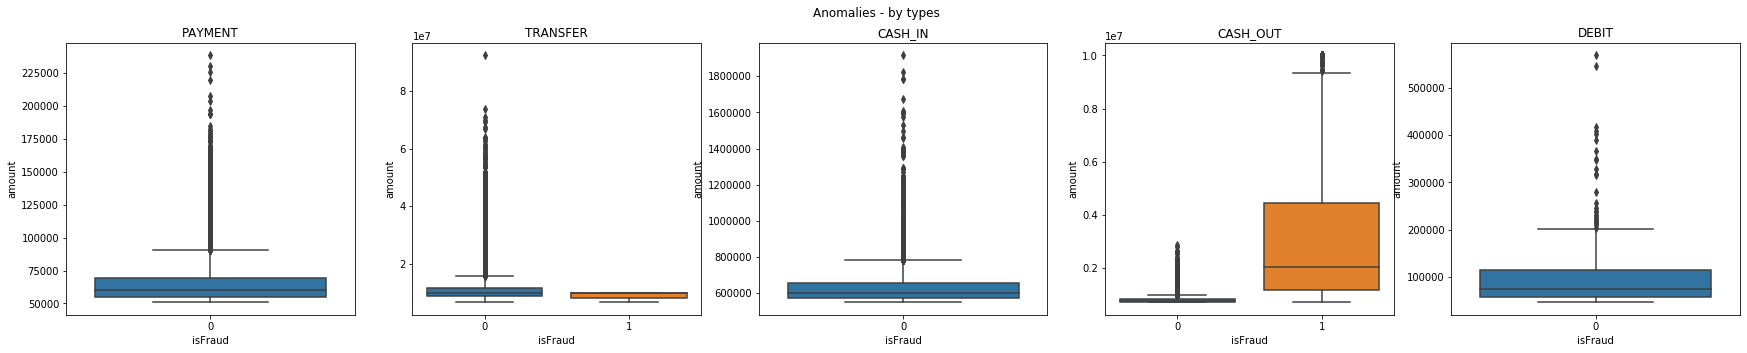

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
fig.suptitle('Anomalies - by types')

type_names = ['PAYMENT', 'TRANSFER', 'CASH_IN', 'CASH_OUT', 'DEBIT']
for i in range(5):
    anomalies, normal = remove_outlier(type_names[i])
    sns.boxplot(ax = axes[i], x = 'isFraud', y = 'amount', data = anomalies)
    axes[i].set_title(type_names[i])
    

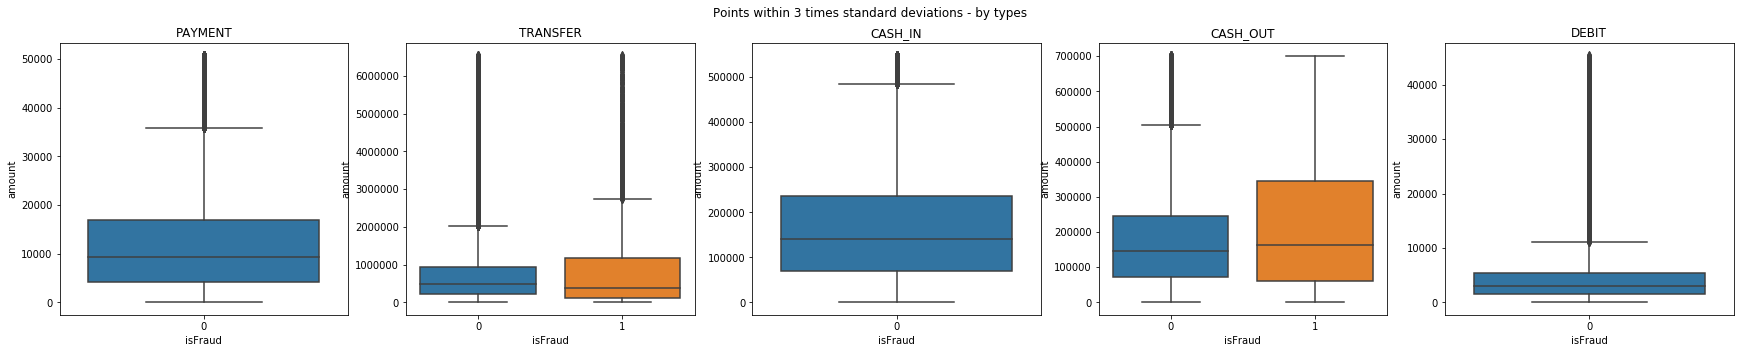

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
fig.suptitle('Points within 3 times standard deviations - by types')

type_names = ['PAYMENT', 'TRANSFER', 'CASH_IN', 'CASH_OUT', 'DEBIT']
for i in range(5):
    anomalies, normal = remove_outlier(type_names[i])
    sns.boxplot(ax = axes[i], x = 'isFraud', y = 'amount', data = normal)
    axes[i].set_title(type_names[i])

It's very interesting to find that there is no fraud situation in PAYMENT, CAHS-IN, DEBIT transcation type!!! This new thought would help us a lot in the following forcasting fraud action.

This inspires us we can split the dataset based on their transcation type, which would make us predict fraud more reasonable and avoid biased dataset!

## Prediction Algorithm 1 -- Traditional Statistical Method

In [159]:
def pie_char(percentage, title, labels_name1, labels_name2):
    fig, ax = plt.subplots()
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = '#909090'
    plt.rcParams['axes.labelcolor']= '#909090'
    plt.rcParams['xtick.color'] = '#909090'
    plt.rcParams['ytick.color'] = '#909090'
    plt.rcParams['font.size'] = 14
    labels = [labels_name1, labels_name2]
    color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                          '#C1F0F6', '#0099CC']
    percentages = [100 - float(percentage*100), float(percentage*100)]
    explode=(0.1,0)
    ax.pie(percentages, explode=explode, labels=labels,  
           colors=color_palette_list[0:2], autopct='%1.0f%%', 
           shadow=False, startangle=0,   
           pctdistance=1.2,labeldistance=1.4)
    ax.axis('equal')
    ax.set_title(title)
    ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

### Type = Transfer

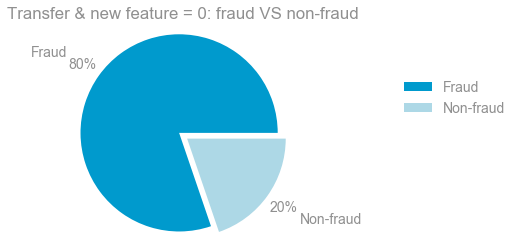

In [162]:
transfer_df = raw_data[raw_data['type'] == 'TRANSFER']
transfer_df['newbalance_orig_dest'] = transfer_df['newbalanceOrig'] + transfer_df['newbalanceDest']
fraud = transfer_df[transfer_df['newbalance_orig_dest'] == 0][transfer_df['isFraud'] == 1]
notfraud = transfer_df[transfer_df['newbalance_orig_dest'] == 0][transfer_df['isFraud'] == 0]
percentage = len(notfraud)/(len(fraud) + len(notfraud))

pie_char(percentage, "Transfer & new feature = 0: fraud VS non-fraud", 'Fraud', 'Non-fraud')

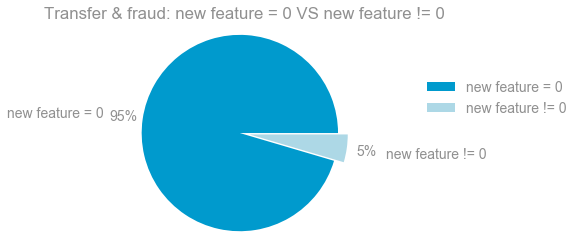

In [163]:
percentage = 1 - len(fraud)/len(transfer_df[transfer_df['isFraud'] == 1])

pie_char(percentage, "Transfer & fraud: new feature = 0 VS new feature != 0", 'new feature = 0', 'new feature != 0')

First we created a new feature *newbalance_orig_dest*,  *newbalance_orig_dest = newbalanceOrig + newbalanceDest*.

We pay much attention to this new feature, especially when *newbalance_orig_dest = 0*, which means customer and recipient's account balance both equal to 0. 

From two pie charts above, we can surprisingly found that this new feature tightly connected to fraud transcation. 

### Type = Cash Out

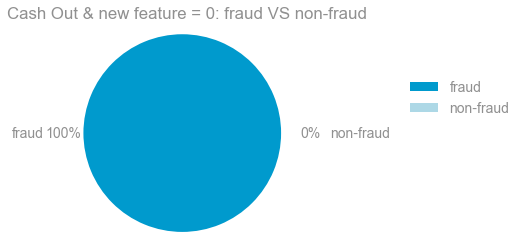

In [166]:
cash_out = raw_data[raw_data['type'] == 'CASH_OUT']
cash_out['new_newbalanceOrig'] = np.where(cash_out['oldbalanceOrg'] - cash_out['amount'] < 0, -1, cash_out['newbalanceOrig'])
fraud = cash_out[cash_out['new_newbalanceOrig'] == 0][cash_out['isFraud'] == 1]
n = cash_out[cash_out['new_newbalanceOrig'] == 0][cash_out['isFraud'] == 0]

percentage = 1 - len(fraud)/(len(fraud) + len(n))

pie_char(percentage, "Cash Out & new feature = 0: fraud VS non-fraud", 'fraud', 'non-fraud')

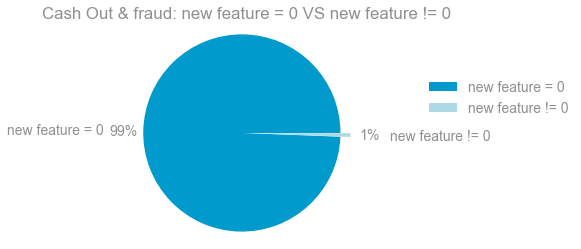

In [167]:
percentage = 1 - len(cash_out[cash_out['new_newbalanceOrig'] == 0])/len(cash_out[cash_out['isFraud'] == 1])

pie_char(percentage, "Cash Out & fraud: new feature = 0 VS new feature != 0", 'new feature = 0', 'new feature != 0')

Same as Transfer, first we created a new feature *new_newbalanceOrig*, *new_newbalanceOrig = -1 if oldbalanceOrg < amount else newbalanceOrig*.

We pay much attention to this new feature, especially when new_newbalanceOrig = 0 as well, this customer extract extactly all the cash out of their account.

From two pie charts above, we can surprisingly found that this new feature super tightly connected to fraud transcation.

Based on the analysis above, to predict fraud transaction, we can design the algorithm as follows:
*   If transcation type within [PAYMENT, CASH IN, DEBIT], then label this transcation as 0
*   If transcation type is TRANSFER, create new feature *newbalance_orig_dest = newbalanceOrig + newbalanceDest*
    *   If new feature == 0: label this transcation as 1
    *   Else: label this transcation as 0
*   If transcation type is CASH OUT, create new feature *new_newbalanceOrig = -1 if oldbalanceOrg < amount else newbalanceOrig*.
    *   If new feature == 0: label this transcation as 1
    *   Else: label this transcation as 0

In [174]:
def predict_fraud(data):
    data['newbalance_orig_dest'] = data['newbalanceOrig'] + data['newbalanceDest']
    data['new_newbalanceOrig'] = np.where(data['oldbalanceOrg'] - data['amount'] < 0, -1, data['newbalanceOrig'])
    
    for i in range(len(data)):
        if data.iloc[i]['type'] in set(['PAYMENT', 'DEBIT', 'CASH_IN']):
            data.iloc[i]['isFlaggedFraud'] = 0
        elif data.iloc[i]['type'] == 'TRANSFER' and data.iloc[i]['newbalance_orig_dest'] == 0:
            data.iloc[i]['isFlaggedFraud'] = 1
        elif data.iloc[i]['type'] == 'CASH_OUT' and data.iloc[i]['new_newbalanceOrig'] == 0:
            data.iloc[i]['isFlaggedFraud'] = 1
    
    return data
            

In [179]:
trainX, testX, trainY, testY = train_test_split(raw_data, raw_data['isFraud'], test_size = 0.2)

In [180]:
predicted_fraud = predict_fraud(testX)

Future Work: Combination with other machine learning models, would make the prediction better.